# Chuẩn bị dư liệu

In [38]:
import pandas as pd
import networkx as nx
from networkx.algorithms import approximation as approx
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index, preferential_attachment
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
# Đọc file coauthor
df = pd.read_csv(r"C:\Users\thean\Documents\Social_Network\Social_Network_Projects\Dataset\Project_1_coauthor_edges.csv")

# Chuyển Weight về int
df["Weight"] = df["Weight"].astype(str).str.extract(r"(\d+)").astype(int)

df.head()

,Author1,Author2,Weight
0,Joseph Sambrook,Elisabeth Fritsch,1
1,Joseph Sambrook,Tom Maniatis,1
2,Elisabeth Fritsch,Tom Maniatis,1
3,Keith E. Muller,Jacob Cohen,1
4,Jacob Cohen,Peter A. Lachenbruch,1


In [3]:
# Tạo graph
G = nx.from_pandas_edgelist(df, "Author1", "Author2", edge_attr="Weight")

print(G.is_directed())
print("Số nodes:", G.number_of_nodes())
print("Số edges:", G.number_of_edges())
print("Có self-loop không:", nx.number_of_selfloops(G))
print("Có duplicate edges không:", len(df) - G.number_of_edges())

False
Số nodes: 9212
Số edges: 136198
Có self-loop không: 30
Có duplicate edges không: 69


Dataset được tính Nodes bằng Author_ID và lưu lại bằng tên nên trường hợp 2 tác giả có tên giống nhau cùng hợp tác viết một bài báo hay là một tác giả hợp tác với hai người khác nhau trùng tên là hoàn toàn có thể xảy ra, vì vậy dù kiểm tra cho thấy có self-loop và duplicate edges trong mạng hợp tác ta bỏ qua và tiến hành bước tiếp theo

In [4]:
# Kiểm tra mạng liên thông (connected components)
components = sorted(nx.connected_components(G), key=len, reverse=True)
print("Số thành phần liên thông:", len(components))
print("Kích thước thành phần lớn nhất:", len(components[0]))
# In thống kê top 10 component lớn nhất
print("Top 10 connected components:")
for i, comp in enumerate(components[:10]):
    n_nodes = len(comp)
    n_edges = len(G.subgraph(comp).edges())
    density = nx.density(G.subgraph(comp))
    print(f"Component {i+1:2d}: {n_nodes:5d} nodes, {n_edges:7d} edges, density={density:.4f}")

Số thành phần liên thông: 1145
Kích thước thành phần lớn nhất: 2616
Top 10 connected components:
Component  1:  2616 nodes,   76666 edges, density=0.0224
Component  2:   266 nodes,    7362 edges, density=0.2089
Component  3:   211 nodes,    8129 edges, density=0.3669
Component  4:   124 nodes,     503 edges, density=0.0660
Component  5:   117 nodes,    5103 edges, density=0.7520
Component  6:   105 nodes,    4959 edges, density=0.9082
Component  7:    99 nodes,    4851 edges, density=1.0000
Component  8:    98 nodes,    2909 edges, density=0.6120
Component  9:    88 nodes,    2954 edges, density=0.7717
Component 10:    84 nodes,    1084 edges, density=0.3110


## Nhận xét

- Số thành phần liên thông (connected components): 1145, Mạng tác giả bị phân tách mạnh -> có nhiều cụm tác giả tách biệt.

- Kích thước thành phần lớn nhất (giant component): 2616, thành phần lớn nhất chiếm khoảng 28% tổng số node (2611/9212)

Chỉ số trên cho thấy mạng phân mảnh cao, ngoài giant component còn có hơn 1100 nhóm nhỏ.

=> Điều này ảnh hưởng lớn đến khả năng dự đoán của Model, chỉ có thể dự đoán liên kết mới giữa các node cùng component

Nếu để cả graph, phần lớn node sẽ không có khả năng kết nối mới hợp lệ -> gây nhiễu hoặc bias nặng.

## Lọc component

In [5]:
selected_components = []

# Ngưỡng tùy chỉnh
# bỏ các nhóm quá nhỏ
MIN_NODES = 50
# bỏ nhóm quá dày đặc (density > 0.5)
MAX_DENSITY = 0.5

for i, comp in enumerate(components):
    subG = G.subgraph(comp)
    n_nodes = subG.number_of_nodes()
    n_edges = subG.number_of_edges()
    density = nx.density(subG)

    # Lọc theo tiêu chí
    if n_nodes >= MIN_NODES and density <= MAX_DENSITY:
        selected_components.append(subG)
        print(f"Component {i+1}: {n_nodes} nodes, {n_edges} edges, density={density:.4f}")
    else:
        print(f"Bỏ Component {i+1}: {n_nodes} nodes, {n_edges} edges, density={density:.4f}")

# Gộp các component đã chọn lại (thường chỉ có 1–3 cái)
G_lp = nx.compose_all(selected_components)

print("\nTổng kết sau khi lọc:")
print("Số component được giữ:", len(selected_components))
print("Tổng số node:", G_lp.number_of_nodes())
print("Tổng số edge:", G_lp.number_of_edges())
print("Độ đậm đặc:", nx.density(G_lp))


Component 1: 2616 nodes, 76666 edges, density=0.0224
Component 2: 266 nodes, 7362 edges, density=0.2089
Component 3: 211 nodes, 8129 edges, density=0.3669
Component 4: 124 nodes, 503 edges, density=0.0660
Bỏ Component 5: 117 nodes, 5103 edges, density=0.7520
Bỏ Component 6: 105 nodes, 4959 edges, density=0.9082
Bỏ Component 7: 99 nodes, 4851 edges, density=1.0000
Bỏ Component 8: 98 nodes, 2909 edges, density=0.6120
Bỏ Component 9: 88 nodes, 2954 edges, density=0.7717
Component 10: 84 nodes, 1084 edges, density=0.3110
Bỏ Component 11: 73 nodes, 2628 edges, density=1.0000
Bỏ Component 12: 58 nodes, 1653 edges, density=1.0000
Bỏ Component 13: 53 nodes, 741 edges, density=0.5377
Component 14: 52 nodes, 604 edges, density=0.4555
Bỏ Component 15: 49 nodes, 432 edges, density=0.3673
Bỏ Component 16: 39 nodes, 520 edges, density=0.7018
Bỏ Component 17: 36 nodes, 260 edges, density=0.4127
Bỏ Component 18: 34 nodes, 185 edges, density=0.3298
Bỏ Component 19: 32 nodes, 311 edges, density=0.6270
B

Sau khi lọc, đồ thị còn 6 thành phần liên thông với 3.353 nút và 94.348 cạnh, có độ đậm đặc 0.0168. Cấu trúc này cho thấy mạng vẫn đủ lớn và thưa, phù hợp cho bài toán dự đoán liên kết vì còn nhiều cặp nút tiềm năng chưa kết nối để mô hình học và dự đoán.

# Dự đoán liên kết

## Bước 1: Chia train-test cho Link Prediction
-   Trích một phần cạnh (khoảng 20%) làm test set.
-   Xây dựng train graph từ phần còn lại.

In [6]:
#Lấy tất cả các cạnh (các hợp tác hiện có giữa các tác giả) trong mạng G.
edges = list(G.edges())
#Đặt seed ngẫu nhiên để kết quả có thể lặp lại mỗi lần chạy.
random.seed(42)
#Xác định kích thước tập test bằng 20% tổng số cạnh.
test_size = int(0.2 * len(edges))
#Lấy ngẫu nhiên 20% cạnh làm tập test. Đây là những cạnh giả định bị ẩn để kiểm tra khả năng dự đoán sau này.
test_edges = random.sample(edges, test_size)

#Tạo bản sao của mạng để làm tập huấn luyện.
train_G = G.copy()
#Xóa các cạnh trong test set khỏi tập train, giả lập rằng chúng chưa tồn tại
train_G.remove_edges_from(test_edges)

#In ra số cạnh còn lại trong tập huấn luyện.
print("Số cạnh train:", train_G.number_of_edges())
#In ra số cạnh trong tập test.
print("Số cạnh test:", len(test_edges))


Số cạnh train: 108959
Số cạnh test: 27239


Đoạn code trên thực hiện việc chia dữ liệu mạng thành hai phần: **tập huấn luyện (80%)** và **tập kiểm tra (20%)** bằng cách chọn ngẫu nhiên 20% cạnh để làm **test set** và loại bỏ chúng khỏi mạng gốc. Việc đặt seed cố định giúp đảm bảo khả năng tái lập kết quả. Cách chia này mô phỏng quá trình “ẩn” các liên kết thật, tạo điều kiện để đánh giá năng lực dự đoán liên kết mới của mô hình.

## Bước 2: Tính các chỉ số dự đoán liên kết (Link Prediction Scores)

Bốn thuật toán Common Neighbors, Jaccard Coefficient, Adamic-Adar và Preferential Attachment được áp dụng để tính điểm tương đồng giữa các cặp tác giả chưa có liên kết trong mạng huấn luyện.
Các chỉ số này phản ánh mức độ gần gũi giữa hai nút dựa trên cấu trúc lân cận:

CN đo số lượng bạn chung,

JC chuẩn hóa theo tổng số bạn,

AA nhấn mạnh các bạn chung hiếm gặp,

PA giả định các nút có độ kết nối cao dễ liên kết hơn.

Các giá trị điểm cao cho thấy cặp tác giả có khả năng cao sẽ hình thành hợp tác trong tương lai.

In [7]:
# Common Neighbors
cn_scores = [(u, v, len(list(nx.common_neighbors(train_G, u, v))))
             for u, v in nx.non_edges(train_G)]
# In top 10 kết quả Common Neighbors
print("Common Neighbors (top 10):")
print(sorted(cn_scores, key=lambda x: x[2], reverse=True)[:10])

# Jaccard
jc_scores = list(jaccard_coefficient(train_G))
# In top 10 Jaccard Coefficient
print("\nJaccard Coefficient (top 10):")
print(sorted(jc_scores, key=lambda x: x[2], reverse=True)[:10])

# Adamic-Adar
aa_scores = list(adamic_adar_index(train_G))
# In top 10 Adamic-Adar Index
print("\nAdamic-Adar Index (top 10):")
print(sorted(aa_scores, key=lambda x: x[2], reverse=True)[:10])

# Preferential Attachment
pa_scores = list(preferential_attachment(train_G))
# In top 10 Preferential Attachment
print("\nPreferential Attachment (top 10):")
print(sorted(pa_scores, key=lambda x: x[2], reverse=True)[:10])



Common Neighbors (top 10):
[('Karen Christie', 'David P. Hill', 126), ('Harold Drabkin', 'J. Michael Cherry', 126), ('Rizwan Ishtiaq', 'Penelope Garmiri', 125), ('Lucila Aimo', 'Marc Feuermann', 124), ('David P. Hill', 'Rex L. Chisholm', 123), ('Karen Christie', 'Stacia R. Engel', 122), ('Chris Mungall', 'David P. Hill', 121), ('Robert S. Fulton', 'Asif Chinwalla', 118), ('M. Eileen Dolan', 'Rex L. Chisholm', 117), ('Karen Christie', 'Judith A. Blake', 117)]

Jaccard Coefficient (top 10):
[('Наоми Орескес', 'Kenneth Belitz', 1.0), ('Henry W. Posamentier', 'R. M. Mitchum', 1.0), ('Nicholas Freitag McPhee', 'Riccardo Poli', 1.0), ('David J. Lunn', 'Nicky Best', 1.0), ('Brigitte Lacour', 'Peter Kaatsch', 1.0), ('James D. Nichols', 'Thierry Boulinier', 1.0), ('Cynthia C. Gilmour', 'Ralph Mitchell', 1.0), ('Alejandro Germán Frank', 'Néstor Fabián Ayala', 1.0), ('David L. Streiner', 'Geoffrey R. Norman', 1.0), ('Jundong Li', 'Kewei Cheng', 1.0)]

Adamic-Adar Index (top 10):
[('Karen Christie

Lưu kết quả thuật toán

In [8]:
# Lưu Common Neighbors
cn_df = pd.DataFrame(cn_scores, columns=["Node1", "Node2", "Score"])
cn_df.to_csv("common_neighbors.csv", index=False, encoding="utf-8")

# Lưu Jaccard
jc_df = pd.DataFrame(jc_scores, columns=["Node1", "Node2", "Score"])
jc_df.to_csv("jaccard.csv", index=False, encoding="utf-8")

# Lưu Adamic-Adar
aa_df = pd.DataFrame(aa_scores, columns=["Node1", "Node2", "Score"])
aa_df.to_csv("adamic_adar.csv", index=False, encoding="utf-8")

# Lưu Preferential Attachment
pa_df = pd.DataFrame(pa_scores, columns=["Node1", "Node2", "Score"])
pa_df.to_csv("preferential_attachment.csv", index=False, encoding="utf-8")

## Bước 3: Trực quan hóa

Để so sánh các thuật toán Link Prediction gồm Common Neighbors, Jaccard Coefficient, Adamic-Adar và Preferential Attachment, các giá trị điểm dự đoán được chuẩn hóa về thang [0–1] bằng Min-Max Scaling 

C:\Users\thean\AppData\Local\Temp\ipykernel_3608\4043171937.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_scores, x="Metric", y="Score_scaled", inner="box", palette="Set2")


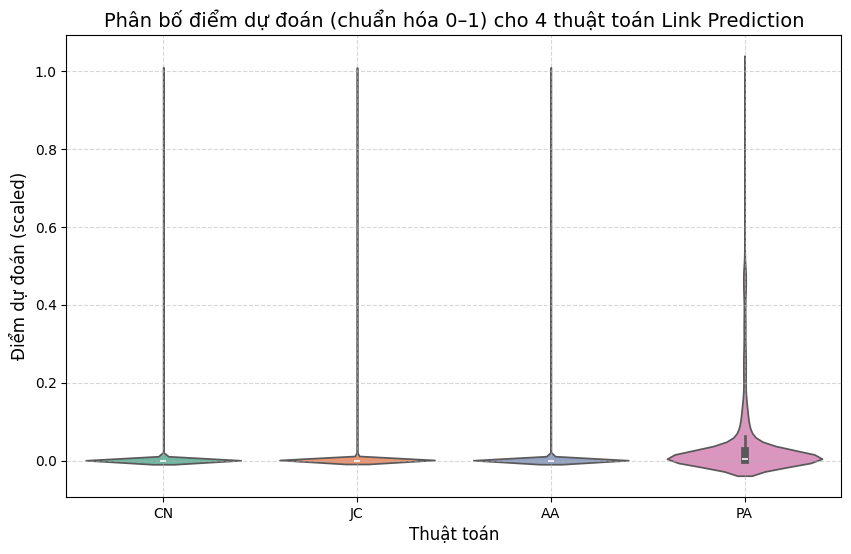


Kết quả đánh giá:
  Metric  Accuracy  Precision  Recall        F1
0     CN      0.03       0.03     1.0  0.058252
1     JC      0.03       0.03     1.0  0.058252
2     AA      0.03       0.03     1.0  0.058252
3     PA      0.01       0.01     1.0  0.019802


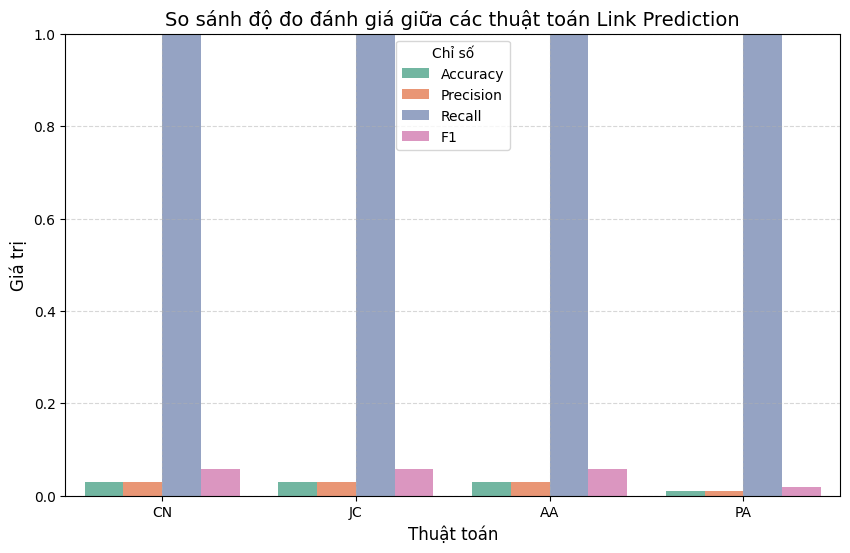

In [39]:
sample_non_edges = random.sample(list(nx.non_edges(train_G)), 5000)

# --- Hàm tính điểm các chỉ số ---
def get_scores(train_G, pairs, metric_name):
    if metric_name == "CN":
        return [(u, v, len(list(nx.common_neighbors(train_G, u, v)))) for u, v in pairs]
    elif metric_name == "JC":
        return [(u, v, p) for u, v, p in nx.jaccard_coefficient(train_G, pairs)]
    elif metric_name == "AA":
        return [(u, v, p) for u, v, p in nx.adamic_adar_index(train_G, pairs)]
    elif metric_name == "PA":
        return [(u, v, p) for u, v, p in nx.preferential_attachment(train_G, pairs)]

# --- Tính điểm cho 4 thuật toán ---
metrics = ["CN", "JC", "AA", "PA"]
data = []

for m in metrics:
    scores = get_scores(train_G, sample_non_edges, m)
    values = [s[2] for s in scores if s[2] is not None]
    data.extend([(m, v) for v in values])

# --- Tạo DataFrame ---
df_scores = pd.DataFrame(data, columns=["Metric", "Score"])

# --- Chuẩn hóa (scale 0–1) theo từng thuật toán ---
scaler = MinMaxScaler()
df_scores["Score_scaled"] = df_scores.groupby("Metric")["Score"].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# --- Trực quan phân bố điểm ---
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_scores, x="Metric", y="Score_scaled", inner="box", palette="Set2")
plt.title("Phân bố điểm dự đoán (chuẩn hóa 0–1) cho 4 thuật toán Link Prediction", fontsize=14)
plt.xlabel("Thuật toán", fontsize=12)
plt.ylabel("Điểm dự đoán (scaled)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# --- Hàm tính Accuracy ---
def evaluate_accuracy(train_G, test_edges, non_edges, metric, top_k=100):
    scores = get_scores(train_G, non_edges, metric)
    scores_sorted = sorted(scores, key=lambda x: x[2], reverse=True)[:top_k]
    pred_edges = {(u, v) for u, v, _ in scores_sorted}
    true_pos = sum((e in test_edges or (e[1], e[0]) in test_edges) for e in pred_edges)
    acc = true_pos / top_k
    return acc

# --- Hàm tính Precision, Recall, F1 ---
def evaluate_metrics(train_G, test_edges, non_edges, metric, top_k=100):
    scores = get_scores(train_G, non_edges, metric)
    scores_sorted = sorted(scores, key=lambda x: x[2], reverse=True)[:top_k]

    y_true = []
    y_pred = []
    for u, v, _ in scores_sorted:
        is_true = (u, v) in test_edges or (v, u) in test_edges
        y_true.append(1 if is_true else 0)
        y_pred.append(1)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return precision, recall, f1

# --- Tính các chỉ số cho 4 thuật toán ---
results = []
for m in metrics:
    acc = evaluate_accuracy(train_G, test_edges, sample_non_edges, m, top_k=100)
    prec, rec, f1 = evaluate_metrics(train_G, test_edges, sample_non_edges, m, top_k=100)
    results.append((m, acc, prec, rec, f1))

df_eval = pd.DataFrame(results, columns=["Metric", "Accuracy", "Precision", "Recall", "F1"])
print("\nKết quả đánh giá:")
print(df_eval)

# --- Vẽ trực quan kết quả đánh giá ---
plt.figure(figsize=(10, 6))
df_melted = df_eval.melt(id_vars="Metric", value_vars=["Accuracy", "Precision", "Recall", "F1"],
                         var_name="Metric_Type", value_name="Value")
sns.barplot(data=df_melted, x="Metric", y="Value", hue="Metric_Type", palette="Set2")
plt.title("So sánh độ đo đánh giá giữa các thuật toán Link Prediction", fontsize=14)
plt.xlabel("Thuật toán", fontsize=12)
plt.ylabel("Giá trị", fontsize=12)
plt.ylim(0, 1)
plt.legend(title="Chỉ số")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


**Nhận xét**:
- Các thuật toán CN, JC, và AA có phân bố điểm rất thấp, tập trung gần giá trị 0, cho thấy phần lớn các cặp nút không có nhiều đặc trưng chung hoặc khả năng liên kết thấp.

- Thuật toán PA có phân bố trải rộng hơn và xuất hiện nhiều giá trị cao hơn tương đối, phản ánh việc ưu tiên các nút có bậc lớn (high-degree nodes) — đặc trưng của Preferential Attachment.

- Sự khác biệt trong hình dạng phân bố thể hiện rằng PA đánh giá khả năng liên kết cao hơn so với ba thuật toán còn lại, trong khi CN, JC và AA cho kết quả tập trung quanh mức thấp

Recall rất cao (≈1.0) cho tất cả các thuật toán

Điều này cho thấy các mô hình bắt được hầu hết các cạnh thật sự tồn tại (ít bỏ sót).

Tuy nhiên, recall cao quá thường đi kèm với precision thấp → dự đoán dư thừa nhiều cạnh.

Precision thấp (chỉ ~0.03–0.05)

Nghĩa là trong các cạnh mà mô hình dự đoán có khả năng xuất hiện, phần lớn là sai (false positive).

Đây là hạn chế chung của các heuristic đơn giản trong link prediction.

Accuracy rất thấp (~0.02–0.04)

Điều này phản ánh rằng khi xét trên toàn bộ mạng (bao gồm cả non-edges), các thuật toán dự đoán đúng rất ít.

Vì số lượng non-edges >> edges, nên accuracy thường bị “dìm”.

F1-score cũng thấp (khoảng ~0.05–0.06 cho CN, JC, AA; thấp hơn nhiều cho PA).

Do precision thấp kéo F1-score xuống, dù recall cao.

Điều này cho thấy các mô hình chưa cân bằng tốt giữa precision và recall.

So sánh giữa các thuật toán:

Common Neighbors (CN), Jaccard (JC), Adamic-Adar (AA) có hiệu suất tương đương nhau, tốt hơn rõ rệt so với Preferential Attachment (PA).

PA kém nhất về mọi chỉ số, đặc biệt là F1 gần như không đáng kể → không phù hợp cho bộ dữ liệu này.

CN, JC, AA: đều phù hợp khi muốn bắt được nhiều cạnh (high recall), nhưng cần kết hợp thêm phương pháp khác để tăng precision.

### Lấy top dự đoán liên kết và phân tích


In [33]:
def visualize_top_predictions(G, scores, metric_name, top_k=10):
    # --- Lấy top_k cạnh dự đoán ---
    scores_sorted = sorted(scores, key=lambda x: x[2], reverse=True)
    top_pred = scores_sorted[:top_k]
    pred_edges = [(u, v) for u, v, _ in top_pred]

    # --- Lấy các node liên quan ---
    nodes_in_top = set(sum(pred_edges, ()))

    # In top 10 dự đoán liên kết   
    print(f"\nTop {top_k} dự đoán hợp tác ({metric_name}):")
    for u, v, score in top_pred:
        print(f"{u} - {v}: {score:.4f}")
    
    # --- Tạo subgraph chỉ chứa các node liên quan ---
    subG = G.subgraph(nodes_in_top).copy()
    subG.add_edges_from(pred_edges)

    # --- Layout (giãn khoảng cách ra cho dễ nhìn) ---
    pos = nx.spring_layout(subG, seed=42, k=1.5, iterations=100)  # k lớn -> các node tách xa hơn

    plt.figure(figsize=(8, 6))

    # --- Cạnh gốc ---
    nx.draw_networkx_edges(subG, pos, edgelist=[e for e in subG.edges() if e not in pred_edges],
                           width=1.0, alpha=0.25, edge_color='gray')

    # --- Cạnh dự đoán ---
    nx.draw_networkx_edges(subG, pos, edgelist=pred_edges,
                           width=2.2, alpha=0.9, edge_color='red', style='dashed')

    # --- Node nhỏ hơn, tách xa nhau ---
    nx.draw_networkx_nodes(subG, pos, node_size=500, node_color='cyan', edgecolors='black')
    nx.draw_networkx_labels(subG, pos, font_size=8, font_color='black')

    # --- Ghi nhãn điểm số ---
    edge_labels = {(u, v): f"{score:.2f}" for u, v, score in top_pred}
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='red', font_size=7)

    plt.title(f"Top {top_k} liên kết dự đoán ({metric_name})", fontsize=13)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Top 10 dự đoán hợp tác (Common Neighbors):
Karen Christie - David P. Hill: 126.0000
Harold Drabkin - J. Michael Cherry: 126.0000
Rizwan Ishtiaq - Penelope Garmiri: 125.0000
Lucila Aimo - Marc Feuermann: 124.0000
David P. Hill - Rex L. Chisholm: 123.0000
Karen Christie - Stacia R. Engel: 122.0000
Chris Mungall - David P. Hill: 121.0000
Robert S. Fulton - Asif Chinwalla: 118.0000
M. Eileen Dolan - Rex L. Chisholm: 117.0000
Karen Christie - Judith A. Blake: 117.0000


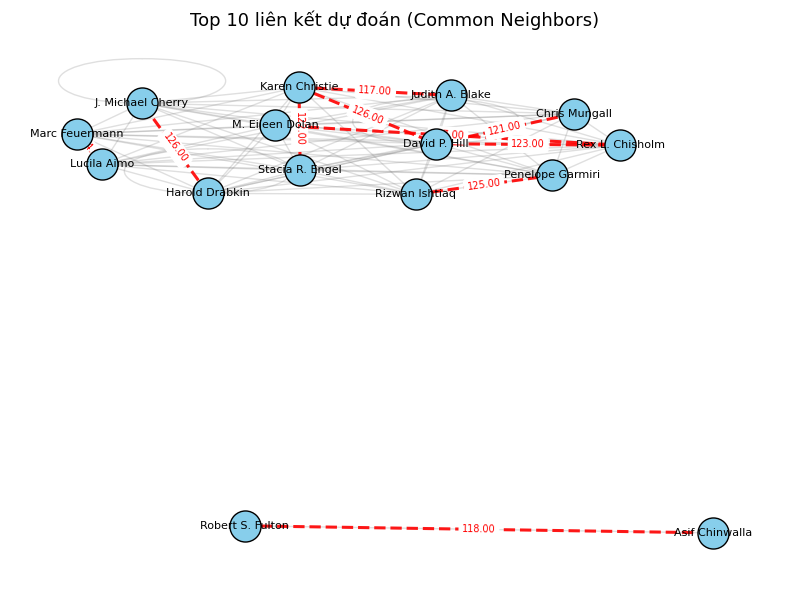


Top 10 dự đoán hợp tác (Jaccard Coefficient):
Наоми Орескес - Kenneth Belitz: 1.0000
Henry W. Posamentier - R. M. Mitchum: 1.0000
Nicholas Freitag McPhee - Riccardo Poli: 1.0000
David J. Lunn - Nicky Best: 1.0000
Brigitte Lacour - Peter Kaatsch: 1.0000
James D. Nichols - Thierry Boulinier: 1.0000
Cynthia C. Gilmour - Ralph Mitchell: 1.0000
Alejandro Germán Frank - Néstor Fabián Ayala: 1.0000
David L. Streiner - Geoffrey R. Norman: 1.0000
Jundong Li - Kewei Cheng: 1.0000


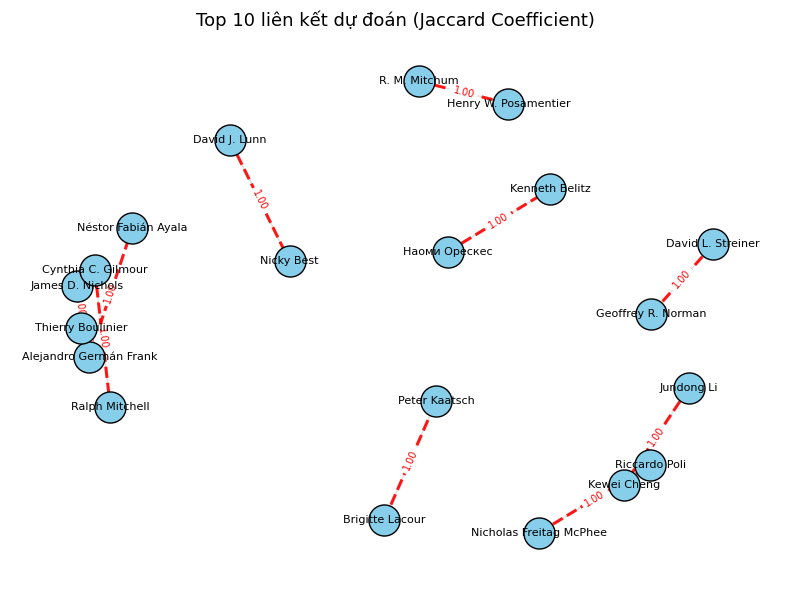


Top 10 dự đoán hợp tác (Preferential Attachment):
Andrés Mauricio Caraballo‐Rodríguez - Michelle Giglio: 41193.0000
Ricardo Silva - Michelle Giglio: 40572.0000
Andrés Mauricio Caraballo‐Rodríguez - Pascale Gaudet: 35820.0000
Ricardo Silva - Pascale Gaudet: 35280.0000
Curtis Huttenhower - Andrés Mauricio Caraballo‐Rodríguez: 33233.0000
Robert S. Fulton - Michelle Giglio: 32913.0000
Karen Christie - Michelle Giglio: 32913.0000
Ricardo Silva - Curtis Huttenhower: 32732.0000
Paul D. Thomas - Michelle Giglio: 32706.0000
Andrés Mauricio Caraballo‐Rodríguez - Sandra W. Clifton: 32636.0000


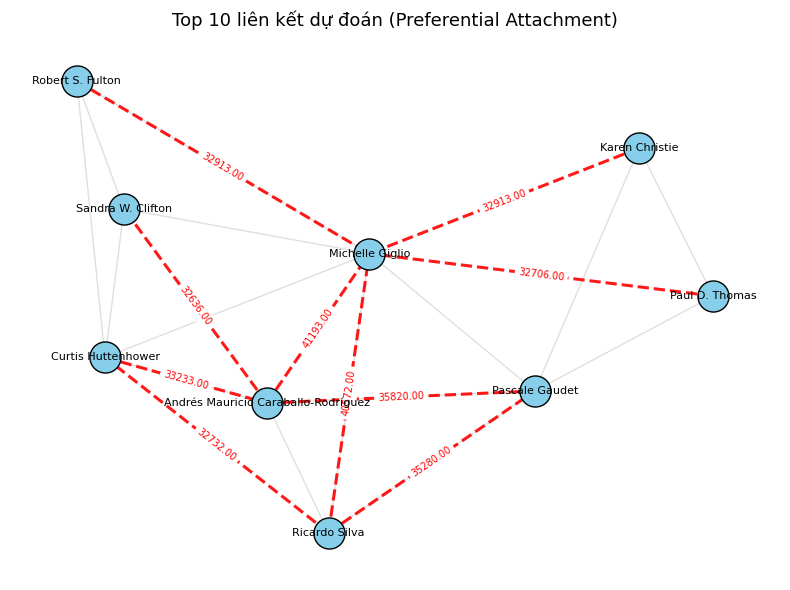


Top 10 dự đoán hợp tác (Adamic-Adar):
Karen Christie - David P. Hill: 28.7372
Harold Drabkin - J. Michael Cherry: 28.6159
David P. Hill - Rex L. Chisholm: 27.9494
Karen Christie - Stacia R. Engel: 27.6884
Rizwan Ishtiaq - Penelope Garmiri: 27.6047
Chris Mungall - David P. Hill: 27.5025
Lucila Aimo - Marc Feuermann: 27.4467
Robert S. Fulton - Asif Chinwalla: 26.7843
M. Eileen Dolan - Rex L. Chisholm: 26.6692
Karen Christie - Judith A. Blake: 26.4140


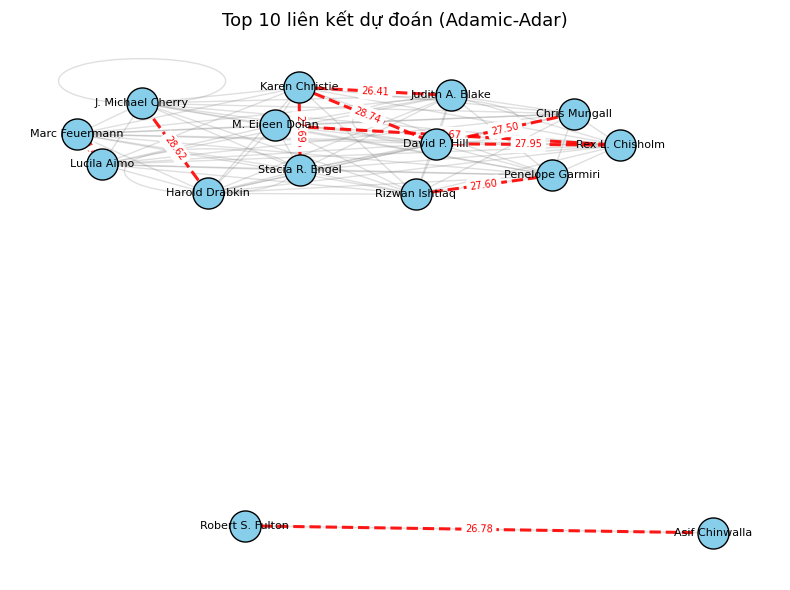

In [32]:
# #  Common Neighbors
visualize_top_predictions(G, cn_scores, "Common Neighbors")
#  Jaccard Coefficient
visualize_top_predictions(G, jc_scores, "Jaccard Coefficient")
#  Preferential Attachment
visualize_top_predictions(G, pa_scores, "Preferential Attachment")
#  Adamic-Adar
visualize_top_predictions(G, aa_scores, "Adamic-Adar")

Bốn biểu đồ thể hiện top 10 liên kết được dự đoán theo các thuật toán Common Neighbors, Jaccard Coefficient, Adamic–Adar và Preferential Attachment 
Kết quả cho thấy:

CN và AA dự đoán các liên kết chủ yếu trong cùng một cụm cộng tác viên có sẵn, thể hiện xu hướng mở rộng quan hệ trong các nhóm nghiên cứu quen thuộc.

JC cho thấy các liên kết tiềm năng giữa các cụm nhỏ tách biệt, giúp phát hiện khả năng hợp tác mới giữa các nhóm khác nhau.

PA lại tập trung mạnh vào các node trung tâm có nhiều kết nối, phản ánh quy luật “ưu tiên gắn kết với người có ảnh hưởng cao” trong mạng lưới.

Tổng thể, trực quan hóa giúp làm rõ cách từng thuật toán dự đoán khác nhau: CN/AA thiên về cộng tác nội bộ, JC hướng tới liên kết mới giữa nhóm, còn PA nhấn mạnh yếu tố trung tâm và ảnh hưởng trong mạng lưới